In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from datetime import timedelta




In [54]:
# Load the data
df = pd.read_csv('synthetic_sales_data.csv')
df

,Date,Temperature,Precipitation,Weather_Conditions,Humidity,Event_Location,Event_Date,Event_Type,Promotion_Type,Promotion_Start_Date,...,Receipt_ID,Item_Sold,Quantity_Sold,Total_Sales_Amount,Item_ID,Item_Name,Current_Stock_Level,Reorder_Point,Lead_Time,Expiration_Date
0,2023-07-25,24.7,18.1,Snowy,78,NaN,NaN,NaN,NaN,NaN,...,992a87cc-b76d-4d15-acd8-4ebcc0e601fc,Sushi Rolls,4,56,ab2547f3-924a-4e45-9569-05b89ed87603,Sushi Rolls,66,19,10,2023-07-29
1,2023-07-25,24.7,18.1,Snowy,78,NaN,NaN,NaN,NaN,NaN,...,992a87cc-b76d-4d15-acd8-4ebcc0e601fc,Swiss Cheese,5,75,17d39137-ab50-4c26-ba1a-b73c43ceae77,Swiss Cheese,348,39,12,2023-07-29
2,2023-07-25,24.7,18.1,Snowy,78,NaN,NaN,NaN,NaN,NaN,...,992a87cc-b76d-4d15-acd8-4ebcc0e601fc,Cottage Cheese,1,5,df017801-9ca6-4b16-a3d3-7dd8b59b8193,Cottage Cheese,158,64,7,2023-08-04
3,2023-07-25,24.7,18.1,Snowy,78,NaN,NaN,NaN,NaN,NaN,...,992a87cc-b76d-4d15-acd8-4ebcc0e601fc,Bread,4,60,d65ae410-965b-4b84-8253-6fd7472d20b3,Bread,208,42,14,2023-07-26
4,2023-07-25,24.7,18.1,Snowy,78,NaN,NaN,NaN,NaN,NaN,...,4a7dea23-8ec9-4919-97a8-ecd097e848fc,Bread,1,4,ec99154a-bc55-481c-a369-fe5303659588,Bread,343,89,3,2023-08-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61843,2024-07-24,14.6,17.6,Rainy,46,NaN,NaN,NaN,NaN,NaN,...,e2ca0ae8-aab1-452a-bb3a-fb0c95ce66c3,Pork,1,16,fb506bf0-17e0-4352-838d-a8036eedce56,Pork,392,18,1,2024-08-05
61844,2024-07-24,14.6,17.6,Rainy,46,NaN,NaN,NaN,NaN,NaN,...,e2ca0ae8-aab1-452a-bb3a-fb0c95ce66c3,Cottage Cheese,3,27,24d49b35-a715-4a22-9917-7c06f5e2b71d,Cottage Cheese,396,59,2,2024-07-27
61845,2024-07-24,14.6,17.6,Rainy,46,NaN,NaN,NaN,NaN,NaN,...,e2ca0ae8-aab1-452a-bb3a-fb0c95ce66c3,Salami,1,25,8a4e21c1-b7ab-4542-bf3b-7ce72ffc7f7a,Salami,266,24,9,2024-07-30
61846,2024-07-24,14.6,17.6,Rainy,46,NaN,NaN,NaN,NaN,NaN,...,e2ca0ae8-aab1-452a-bb3a-fb0c95ce66c3,Apples,4,4,ae5d9208-ae6f-443a-9dfe-aa1ca68cd386,Apples,398,52,3,2024-07-27


In [55]:
# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df = df.sort_values('Date')

In [56]:
# Function to encode categorical variables
def encode_categorical(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    return df, le

# Encode categorical variables
categorical_columns = ['Weather_Conditions', 'Event_Type', 'Promotion_Type', 'Item_Name']
encoders = {}

for col in categorical_columns:
    df, encoders[col] = encode_categorical(df, col)

In [57]:

# Ensure date columns are in datetime format
date_columns = ['Date', 'Event_Date', 'Promotion_Start_Date', 'Promotion_End_Date', 'Expiration_Date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # Convert columns to datetime

# Convert date columns to numerical (days since the start)
start_date = df['Date'].min()
for col in date_columns:
    df[col] = (df[col] - start_date).dt.days

# Fill NaN values
df = df.fillna(0)

In [58]:
# Group by date
daily_data = df.groupby('Date').agg({
    'Temperature': 'mean',
    'Precipitation': 'mean',
    'Humidity': 'mean',
    'Weather_Conditions': 'first',
    'Event_Location': lambda x: x.notnull().any(),
    'Event_Date': 'first',
    'Event_Type': 'first',
    'Promotion_Type': 'first',
    'Promotion_Start_Date': 'first',
    'Promotion_End_Date': 'first',
    'Promotion_Discount': 'mean',
    'Quantity_Sold': 'sum',
    'Total_Sales_Amount': 'sum',
    'Current_Stock_Level': 'mean',
    'Reorder_Point': 'mean',
    'Lead_Time': 'mean',
    'Expiration_Date': 'mean'
}).reset_index()

In [59]:

# Create lag features (previous 7 days)
for col in daily_data.columns:
    if col != 'Date':
        for i in range(1, 8):
            daily_data[f'{col}_lag_{i}'] = daily_data[col].shift(i)

# Drop rows with NaN values after creating lag features
daily_data = daily_data.dropna()

# Normalize the data
scaler = MinMaxScaler()
daily_data_scaled = pd.DataFrame(scaler.fit_transform(daily_data.drop('Date', axis=1)), 
                                 columns=daily_data.columns.drop('Date'))

C:\Users\USER\AppData\Local\Temp\ipykernel_29096\857358356.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'{col}_lag_{i}'] = daily_data[col].shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_29096\857358356.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_data[f'{col}_lag_{i}'] = daily_data[col].shift(i)
C:\Users\USER\AppData\Local\Temp\ipykernel_29096\857358356.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor pe

In [60]:
# Prepare sequences for time series forecasting
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:(i + n_steps_in)])
        y.append(data[(i + n_steps_in):(i + n_steps_in + n_steps_out)])
    return np.array(X), np.array(y)

n_steps_in = 30  # Number of days to use as input
n_steps_out = 7  # Number of days to predict

X, y = create_sequences(daily_data_scaled.values, n_steps_in, n_steps_out)

In [61]:


# # Split the data into train and test sets
# train_size = int(len(X) * 0.8)
# X_train, X_test = X[:train_size], X[train_size:]
# y_train, y_test = y[:train_size], y[train_size:]

# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)

from sklearn.model_selection import train_test_split

# Assuming X and y are your features and target variables

# Split into train and temp sets (which will be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)



X_train shape: (258, 30, 136)
y_train shape: (258, 7, 136)
X_val shape: (32, 30, 136)
y_val shape: (32, 7, 136)
X_test shape: (33, 30, 136)
y_test shape: (33, 7, 136)


In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

n_steps_in = 30
n_features = 136
n_steps_out = 7

model1 = Sequential([
    InputLayer((n_steps_in, n_features)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(n_steps_out * n_features, activation='linear'),
    Reshape((n_steps_out, n_features))
])

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 952)            │        16,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 136)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,584 (314.78 KB)

 Trainable params: 80,584 (314.78 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
cp1 = ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [64]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1])

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.2980 - root_mean_squared_error: 0.5459 - val_loss: 0.2957 - val_root_mean_squared_error: 0.5438
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2906 - root_mean_squared_error: 0.5390 - val_loss: 0.2931 - val_root_mean_squared_error: 0.5414
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2923 - root_mean_squared_error: 0.5406 - val_loss: 0.2895 - val_root_mean_squared_error: 0.5381
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.2875 - root_mean_squared_error: 0.5362 - val_loss: 0.2852 - val_root_mean_squared_error: 0.5340
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2832 - root_mean_squared_error: 0.5322 - val_loss: 0.2797 - val_root_mean_squared_error: 0.5289
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2767 - root_mean_squared_error: 0.5260 - val_loss: 0.2725 - val_root_mean_squared_error: 0.5220
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2692

In [65]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/best_model.keras')

In [66]:
# Generate predictions for the training data
train_predictions = model1.predict(X_train)

# Flatten the predictions and actual values
# Note: y_train has shape (samples, n_steps_out, n_features)
# Flattening y_train to match the shape of predictions
y_train_flat = y_train.reshape(-1, y_train.shape[-1])

# Flatten the predictions
train_predictions_flat = train_predictions.reshape(-1, train_predictions.shape[-1])

# Create a DataFrame to show the results
train_results = pd.DataFrame(data={
    'Train Predictions': np.concatenate(train_predictions_flat, axis=0),
    'Actuals': np.concatenate(y_train_flat, axis=0)
})

print(train_results.head())


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step
   Train Predictions   Actuals
0           0.513285  0.290323
1           0.473617  0.778894
2           0.507186  0.262500
3           0.528661  1.000000
4          -0.004241  0.000000


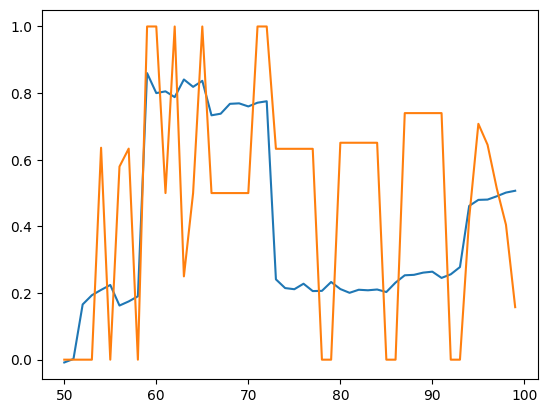

In [68]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [70]:
# Generate predictions for the test data
test_predictions = model1.predict(X_test)

# Flatten the predictions and actual values
# Note: y_test has shape (samples, n_steps_out, n_features)
# Flattening y_test to match the shape of predictions
y_test_flat = y_test.reshape(-1, y_test.shape[-1])

# Flatten the predictions
test_predictions_flat = test_predictions.reshape(-1, test_predictions.shape[-1])

# Create a DataFrame to show the results
test_results = pd.DataFrame(data={
    'Test Predictions': np.concatenate(test_predictions_flat, axis=0),
    'Actuals': np.concatenate(y_test_flat, axis=0)
})

print(test_results.head())


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
   Test Predictions   Actuals
0          0.512693  0.673387
1          0.522191  0.376884
2          0.524792  0.512500
3          0.497082  0.333333
4          0.005385  0.000000


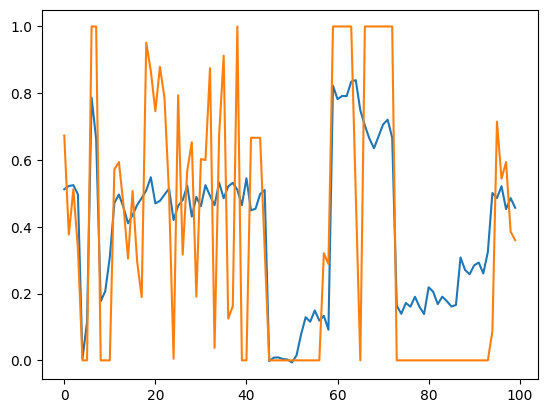

In [71]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])